## Import dependencies

In [37]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge, SGDRegressor
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

## Clean the data

In [38]:
# read in data, trim off the top blank rows
df = pd.read_csv("conoco_data.csv")
# The first 15 rows are empty, get rid of them
df.columns = df.iloc[15]
df = df[16:]
# replace NaN with 0 (I know we said median before but the dataframe isn't being nice now)
df.fillna(0, inplace=True)
df.reset_index(inplace=True)
# create a copy to be used later for second model
copy_df = df.copy(deep=True)

In [39]:
# capture y, our response variable we're trying to predict
y = df["DAYSTILFAIL"].to_numpy()

In [40]:
# list of columns that we do not need, either due to their formatting or what they represent.
drop_cols = ['DAYSTILFAIL', 'WELLNAME', 'index', 'CURRENTWELLSTATUS1', 'DTTMSPUD', 'aRod_DTTMRUN', 'aRod_DTTMPULL', 'POPDATE', 'FAILUREDATE', 
                'JobATub_DTTMRUN', 'JobATub_DTTMPULL', 'HAS_FAILED']
df.drop(columns=drop_cols, inplace=True)

## Create X, scale X and y

In [41]:
X_cols = df.columns
X = df.to_numpy()

# Scaler we used before, no longer used
scaler = MinMaxScaler()

# I honestly don't know why this needs to happen but it does
y = y.reshape(-1, 1)
X_minmax = scaler.fit_transform(X)
y_minmax = scaler.fit_transform(y)

# Create a train-test split of our data
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y_minmax, test_size=0.33, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Model selection

In [42]:
# Fit data to our Random Forest model
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

/Users/ethanzh/Code/rod-pump-analysis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

## Feature importances

In [43]:
# use the random forest regressor to determine which features are the most important
importances = rfr.feature_importances_
# dictionary comprehension to easily visualize data
feature_dict = {feature:value for (feature, value) in zip(X_cols, importances)}
feature_dict

{'TDCALC': 0.0698260137573254,
 'ROD_DEPTHBTM': 0.05574184368866677,
 'TUB_DEPTHBTM': 0.06689859059688988,
 'TUBINGPULL': 0.03817352612853171,
 'median_Consecutive_Pumpoff_Strokes_Allowed': 0.0072023926430786955,
 'mean_Consecutive_Pumpoff_Strokes_Allowed': 0.05736133142795415,
 'median_Current_PIP': 0.02341163630449927,
 'mean_Current_PIP': 0.006429040378119413,
 'median_Cycles': 0.1979196846861937,
 'mean_Cycles': 0.030608315627061615,
 'median_Fluid_Load': 0.020955732894250578,
 'mean_Fluid_Load': 0.02093805904194332,
 'median_Last_Stroke_Min_Load': 0.015124915053705935,
 'mean_Last_Stroke_Min_Load': 0.016279727079178807,
 'median_Last_Stroke_Peak_Load': 0.014442343002215965,
 'mean_Last_Stroke_Peak_Load': 0.012077642179357024,
 'median_STROKE_LENGTH': 0.015036917683751825,
 'mean_STROKE_LENGTH': 0.02860462098710812,
 'median_Pump_Size': 0.0039627220177036685,
 'mean_Pump_Size': 0.011852314354991945,
 'median_Reference_Pump_Fillage': 0.006684064827021687,
 'mean_Reference_Pump_Filla

In [44]:
# here is our r^2 value
rfr.score(X_test, y_test)

0.3625921690071857

In [45]:
# get a list of all importances, sorted
sorted_importances = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)
sorted_importances

[('median_Cycles', 0.1979196846861937),
 ('mean_Percent_Run', 0.07009363023251657),
 ('TDCALC', 0.0698260137573254),
 ('TUB_DEPTHBTM', 0.06689859059688988),
 ('mean_Consecutive_Pumpoff_Strokes_Allowed', 0.05736133142795415),
 ('ROD_DEPTHBTM', 0.05574184368866677),
 ('mean_Yesterday_Min_Load', 0.0487258743733836),
 ('TUBINGPULL', 0.03817352612853171),
 ('mean_Total_Strokes', 0.03695105215676439),
 ('mean_Cycles', 0.030608315627061615),
 ('mean_STROKE_LENGTH', 0.02860462098710812),
 ('mean_Reference_Pump_Fillage', 0.024654658430377566),
 ('median_Current_PIP', 0.02341163630449927),
 ('median_Total_Strokes', 0.0232513029190457),
 ('median_Percent_Run', 0.02262553011507878),
 ('median_Yesterday_Min_Load', 0.021285267860389614),
 ('median_Fluid_Load', 0.020955732894250578),
 ('mean_Fluid_Load', 0.02093805904194332),
 ('mean_Yesterday_Peak_Load', 0.016655392121688633),
 ('mean_Last_Stroke_Min_Load', 0.016279727079178807),
 ('median_Yesterday_Peak_Load', 0.016225857431205713),
 ('median_Last_

## Create new model only using our important features

In [46]:
# Very similar to before, this time we're using only important columns
COLS_NEEDED = 5
cols_to_keep = [x[0] for x in sorted_importances[:COLS_NEEDED]]
more_cols_to_drop = [x[0] for x in sorted_importances[COLS_NEEDED:]]

# create new array of cols to drop
drop_cols = drop_cols + more_cols_to_drop

fresh_df = copy_df.copy(deep=True)
fresh_df.drop(columns=drop_cols, inplace=True)
X_cols = fresh_df.columns
X = fresh_df.to_numpy()
scaler = MinMaxScaler()

y = y.reshape(-1, 1)
X_minmax = scaler.fit_transform(X)
y_minmax = scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y_minmax, test_size=0.33, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Updated feature importances

In [47]:
# perform the same function we did before, except just with these 5 features
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

# use the random forest regressor to determine which features are the most important
importances = rfr.feature_importances_
feature_dict = {feature:value for (feature, value) in zip(X_cols, importances)}

# get a list of all importances, sorted
sorted_importances = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)
sorted_importances

/Users/ethanzh/Code/rod-pump-analysis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[('median_Cycles', 0.24989941279819514),
 ('mean_Percent_Run', 0.20879017379979872),
 ('mean_Consecutive_Pumpoff_Strokes_Allowed', 0.19353589697915272),
 ('TUB_DEPTHBTM', 0.1858446445983291),
 ('TDCALC', 0.16192987182452445)]

## Stochastic Gradient Descent model

In [48]:
# Train our SGD model, then score it
sgd = SGDRegressor(max_iter=100000, tol=1)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.15980731078167476
Mean Squared Error: 0.04855435731696723
Root Mean Squared Error: 0.2203505328266016


/Users/ethanzh/Code/rod-pump-analysis/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Figure of predicted values

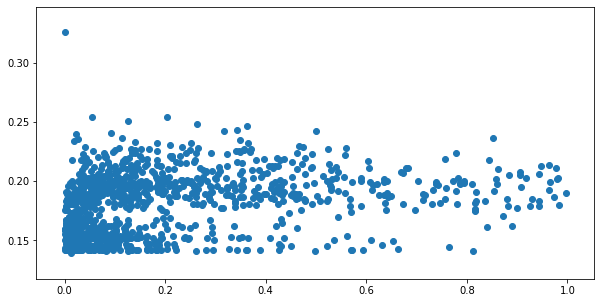

In [50]:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred)